# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_194  Q9NZ94;Q9NZ94-2;Q9NZ94-3   13.244
Sample_054  A6XMH3;P01236;Q5I0G2       13.199
Sample_105  P62805                     16.890
Sample_117  A0A075B6K5                 17.650
Sample_162  H0YNK6;Q06418              17.412
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups
Sample_125  Q8IUC8           16.249
Sample_058  P10909-3         21.321
Sample_158  Q2UY09           14.344
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.716
            A0A075B6Q5                 13.058
            A0A075B6R2                 12.388
            A0A075B6S5                 13.946
            A0A087WSY4                 11.620
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.925
            Q9UI40;Q9UI40-2            14.247
            Q9UIW2                     12.600
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.959
            Q9UP79                     12.050
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.679,15.050,16.842,19.863,15.987,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.593,19.067,...,15.528,15.576,14.055,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.099,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.151,17.705,17.039,15.476,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.188,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.495,15.345,17.084,18.708,14.249,19.433,12.050,10.868
Sample_207,15.739,16.877,15.469,16.898,14.223,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.716,...,16.012,15.178,11.927,15.050,16.842,19.863,11.248,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.412,19.067,16.188,...,15.528,15.576,11.692,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.693,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,11.684,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.343,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.936,15.345,17.084,18.708,14.249,19.433,12.429,13.711
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 408.05it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.27it/s]

100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

100%|██████████| 3/3 [00:00<00:00,  3.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.94it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.96it/s]

100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.89it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.02it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.72it/s]

100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.98it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.50it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.04it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.73it/s]

100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.18it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.39it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.04it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.78it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.69it/s]

100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.22it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.27it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.88it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.72it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.57it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.48it/s]

100%|██████████| 8/8 [00:02<00:00,  2.69it/s]

100%|██████████| 8/8 [00:02<00:00,  2.79it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.61it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.28it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.23it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.08it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  3.00it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.78it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.65it/s]

100%|██████████| 9/9 [00:02<00:00,  2.90it/s]

100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.58it/s]

 30%|███       | 3/10 [00:00<00:01,  3.82it/s]

 40%|████      | 4/10 [00:01<00:01,  3.23it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.85it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.84it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.68it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.64it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.57it/s]

100%|██████████| 10/10 [00:03<00:00,  2.51it/s]

100%|██████████| 10/10 [00:03<00:00,  2.82it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.58it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.23it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.91it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.73it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.56it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.55it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.55it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.50it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.30it/s]

100%|██████████| 11/11 [00:04<00:00,  2.48it/s]

100%|██████████| 11/11 [00:04<00:00,  2.63it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.47it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.29it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.03it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.75it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.70it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.62it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.56it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.44it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.45it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.42it/s]

100%|██████████| 12/12 [00:04<00:00,  2.52it/s]

100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.99it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.20it/s]

 31%|███       | 4/13 [00:01<00:03,  2.94it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.65it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.59it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.52it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.52it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.52it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.47it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.41it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.38it/s]

100%|██████████| 13/13 [00:04<00:00,  2.52it/s]

100%|██████████| 13/13 [00:04<00:00,  2.60it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.38it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.62it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.39it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.42it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.38it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.38it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.37it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.39it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.49it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.45it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.45it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.55it/s]

100%|██████████| 14/14 [00:05<00:00,  2.55it/s]

100%|██████████| 14/14 [00:05<00:00,  2.50it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.88it/s]

 20%|██        | 3/15 [00:01<00:04,  2.77it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.73it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.73it/s]

 40%|████      | 6/15 [00:02<00:03,  2.74it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.68it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.60it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.50it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.58it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.59it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.60it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.63it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.60it/s]

100%|██████████| 15/15 [00:05<00:00,  2.61it/s]

100%|██████████| 15/15 [00:05<00:00,  2.66it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.049 0.017          0.799 0.303       0.122   
2             0.004 0.002      0.048 0.003          0.709 0.089       0.603   
3             0.004 0.000      0.050 0.010          0.684 0.089       0.618   
4             0.004 0.000      0.048 0.003          0.721 0.082       0.676   
5             0.004 0.000      0.048 0.001          0.701 0.082       0.658   
6             0.004 0.000      0.048 0.001          0.723 0.081       0.699   
7             0.004 0.000      0.050 0.015          0.786 0.082       0.806   
8             0.004 0.002      0.055 0.024          0.793 0.086       0.807   
9             0.004 0.000      0.045 0.008          0.821 0.080       0.819   
10            0.004 0.000      0.043 0.005          0.823 0.079       0.828   
11            0.004 0.000      0.051 0.014          0.830 0.077       0.849   
12            0.004 0.000      0.053 0.015          0.842 0.073       0.835   
13            0.004 0.000      0.050 0.013          0.841 0.075       0.832   
14            0.004 0.002      0.052 0.014          0.838 0.076       0.833   
15            0.004 0.002      0.052 0.014          0.841 0.086       0.822   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.204 0.125                  0.553 0.041        0.858   
2          0.102   0.646 0.079                  0.709 0.058        0.787   
3          0.108   0.644 0.082                  0.703 0.062        0.780   
4          0.106   0.692 0.078                  0.741 0.061        0.800   
5          0.110   0.672 0.074                  0.724 0.053        0.799   
6          0.104   0.705 0.070                  0.749 0.055        0.817   
7          0.111   0.791 0.077                  0.821 0.066        0.906   
8          0.108   0.795 0.076                  0.825 0.065        0.904   
9          0.109   0.817 0.079                  0.844 0.067        0.917   
10         0.107   0.822 0.079                  0.849 0.068        0.917   
11         0.100   0.836 0.073                  0.860 0.063        0.921   
12         0.099   0.836 0.072                  0.860 0.062        0.924   
13         0.099   0.834 0.073                  0.858 0.062        0.923   
14         0.097   0.833 0.073                  0.857 0.063        0.922   
15         0.097   0.827 0.069                  0.852 0.058        0.926   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.830 0.091        210.000 0.000  
2          0.068                  0.763 0.086        210.000 0.000  
3          0.067                  0.754 0.084        210.000 0.000  
4          0.066                  0.768 0.084        210.000 0.000  
5          0.060                  0.761 0.079        210.000 0.000  
6          0.058                  0.791 0.075        210.000 0.000  
7          0.049                  0.884 0.057        210.000 0.000  
8          0.049                  0.880 0.057        210.000 0.000  
9          0.048                  0.904 0.052        210.000 0.000  
10         0.048                  0.904 0.053        210.000 0.000  
11         0.047                  0.914 0.046        210.000 0.000  
12         0.046                  0.916 0.047        210.000 0.000  
13         0.047                  0.915 0.048        210.000 0.000  
14         0.047                  0.914 0.048        210.000 0.000  
15         0.043                  0.918 0.042 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 479.08it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.82it/s]

100%|██████████| 3/3 [00:01<00:00,  2.60it/s]

100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.41it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.75it/s]

100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.54it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.42it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.34it/s]

100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

100%|██████████| 5/5 [00:02<00:00,  2.40it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.40it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.50it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.16it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.19it/s]

100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.05it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.17it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  1.93it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.94it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.19it/s]

100%|██████████| 7/7 [00:03<00:00,  2.32it/s]

100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:02,  2.39it/s]

 38%|███▊      | 3/8 [00:01<00:02,  1.95it/s]

 50%|█████     | 4/8 [00:02<00:02,  1.81it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.87it/s]

 75%|███████▌  | 6/8 [00:03<00:00,  2.03it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  2.14it/s]

100%|██████████| 8/8 [00:03<00:00,  2.19it/s]

100%|██████████| 8/8 [00:03<00:00,  2.07it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:02,  2.95it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.27it/s]

 44%|████▍     | 4/9 [00:01<00:02,  1.92it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.79it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.97it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.81it/s]

 89%|████████▉ | 8/9 [00:04<00:00,  1.79it/s]

100%|██████████| 9/9 [00:04<00:00,  1.72it/s]

100%|██████████| 9/9 [00:04<00:00,  1.87it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.77it/s]

 30%|███       | 3/10 [00:01<00:02,  2.63it/s]

 40%|████      | 4/10 [00:01<00:02,  2.06it/s]

 50%|█████     | 5/10 [00:02<00:02,  1.78it/s]

 60%|██████    | 6/10 [00:03<00:02,  1.67it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.82it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.98it/s]

 90%|█████████ | 9/10 [00:04<00:00,  2.13it/s]

100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

100%|██████████| 10/10 [00:04<00:00,  2.10it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.46it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.17it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.95it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.18it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  1.83it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.75it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.76it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.71it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.65it/s]

100%|██████████| 11/11 [00:05<00:00,  1.67it/s]

100%|██████████| 11/11 [00:05<00:00,  1.92it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.86it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.36it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.42it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.06it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.65it/s]

 58%|█████▊    | 7/12 [00:03<00:03,  1.50it/s]

 67%|██████▋   | 8/12 [00:04<00:02,  1.53it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.73it/s]

 83%|████████▎ | 10/12 [00:05<00:01,  1.89it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.96it/s]

100%|██████████| 12/12 [00:06<00:00,  2.02it/s]

100%|██████████| 12/12 [00:06<00:00,  1.97it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.23it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.40it/s]

 31%|███       | 4/13 [00:01<00:03,  2.89it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.55it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.36it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.36it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.14it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.02it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.84it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.77it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.99it/s]

100%|██████████| 13/13 [00:05<00:00,  2.13it/s]

100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.49it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.38it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.93it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.76it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.61it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.58it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.55it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.14it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.92it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.80it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.64it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.60it/s]

100%|██████████| 14/14 [00:06<00:00,  1.66it/s]

100%|██████████| 14/14 [00:06<00:00,  2.08it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.53it/s]

 20%|██        | 3/15 [00:00<00:03,  3.22it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.81it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.74it/s]

 40%|████      | 6/15 [00:02<00:03,  2.32it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.15it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.94it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.68it/s]

 67%|██████▋   | 10/15 [00:04<00:03,  1.63it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.64it/s]

 80%|████████  | 12/15 [00:06<00:01,  1.62it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.56it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.75it/s]

100%|██████████| 15/15 [00:07<00:00,  1.93it/s]

100%|██████████| 15/15 [00:07<00:00,  1.98it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.052 0.013          0.504 0.455       0.057   
2             0.004 0.002      0.061 0.022          0.707 0.121       0.607   
3             0.004 0.002      0.060 0.023          0.788 0.083       0.715   
4             0.005 0.004      0.062 0.023          0.789 0.078       0.713   
5             0.005 0.003      0.061 0.018          0.808 0.091       0.722   
6             0.005 0.003      0.058 0.019          0.819 0.088       0.785   
7             0.007 0.005      0.074 0.036          0.829 0.095       0.788   
8             0.006 0.006      0.080 0.034          0.845 0.091       0.819   
9             0.005 0.004      0.069 0.025          0.844 0.090       0.821   
10            0.006 0.006      0.084 0.036          0.845 0.090       0.814   
11            0.006 0.004      0.070 0.025          0.841 0.082       0.828   
12            0.006 0.004      0.065 0.027          0.832 0.086       0.844   
13            0.006 0.005      0.076 0.033          0.835 0.086       0.835   
14            0.006 0.004      0.078 0.031          0.840 0.083       0.833   
15            0.006 0.005      0.063 0.025          0.853 0.079       0.837   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.067   0.098 0.106                  0.523 0.029        0.879   
2          0.127   0.643 0.097                  0.706 0.071        0.786   
3          0.114   0.745 0.084                  0.786 0.064        0.867   
4          0.108   0.745 0.079                  0.786 0.061        0.869   
5          0.115   0.757 0.084                  0.797 0.063        0.872   
6          0.104   0.797 0.078                  0.827 0.064        0.902   
7          0.114   0.802 0.082                  0.832 0.067        0.908   
8          0.107   0.827 0.073                  0.852 0.062        0.924   
9          0.105   0.827 0.071                  0.852 0.061        0.922   
10         0.109   0.823 0.073                  0.850 0.061        0.921   
11         0.097   0.830 0.066                  0.855 0.056        0.925   
12         0.094   0.833 0.064                  0.857 0.056        0.936   
13         0.098   0.830 0.064                  0.854 0.056        0.936   
14         0.097   0.831 0.061                  0.856 0.053        0.936   
15         0.106   0.839 0.065                  0.864 0.055        0.941   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.056                  0.842 0.087        210.000 0.000  
2          0.075                  0.707 0.100        210.000 0.000  
3          0.057                  0.851 0.068        210.000 0.000  
4          0.055                  0.848 0.073        210.000 0.000  
5          0.056                  0.860 0.062        210.000 0.000  
6          0.048                  0.882 0.061        210.000 0.000  
7          0.049                  0.889 0.063        210.000 0.000  
8          0.047                  0.910 0.061        210.000 0.000  
9          0.048                  0.908 0.063        210.000 0.000  
10         0.048                  0.906 0.063        210.000 0.000  
11         0.046                  0.913 0.056        210.000 0.000  
12         0.043                  0.928 0.049        210.000 0.000  
13         0.043                  0.927 0.049        210.000 0.000  
14         0.042                  0.927 0.048        210.000 0.000  
15         0.039                  0.933 0.046 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 856.85it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 26.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.77it/s]

100%|██████████| 3/3 [00:00<00:00, 17.64it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.18it/s]

100%|██████████| 4/4 [00:00<00:00, 12.61it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 13.81it/s]

100%|██████████| 5/5 [00:00<00:00, 12.50it/s]

100%|██████████| 5/5 [00:00<00:00, 12.63it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 19.22it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 13.93it/s]

100%|██████████| 6/6 [00:00<00:00, 11.28it/s]

100%|██████████| 6/6 [00:00<00:00, 12.10it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 17.82it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.93it/s]

100%|██████████| 7/7 [00:00<00:00, 13.96it/s]

100%|██████████| 7/7 [00:00<00:00, 14.45it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 14.47it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 13.06it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 11.43it/s]

100%|██████████| 8/8 [00:00<00:00, 11.70it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 16.43it/s]

 44%|████▍     | 4/9 [00:00<00:00, 12.75it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 11.10it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 12.01it/s]

100%|██████████| 9/9 [00:00<00:00, 11.72it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 17.52it/s]

 40%|████      | 4/10 [00:00<00:00, 10.85it/s]

 60%|██████    | 6/10 [00:00<00:00, 10.17it/s]

 80%|████████  | 8/10 [00:00<00:00, 10.12it/s]

100%|██████████| 10/10 [00:00<00:00, 10.50it/s]

100%|██████████| 10/10 [00:00<00:00, 10.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 18.83it/s]

 45%|████▌     | 5/11 [00:00<00:00, 14.07it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 11.07it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.36it/s]

100%|██████████| 11/11 [00:01<00:00,  9.60it/s]

100%|██████████| 11/11 [00:01<00:00, 10.69it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.51it/s]

 42%|████▏     | 5/12 [00:00<00:00, 15.09it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.42it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.72it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.25it/s]

100%|██████████| 12/12 [00:00<00:00, 13.04it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 20.30it/s]

 46%|████▌     | 6/13 [00:00<00:00, 13.87it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.10it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 12.41it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 12.53it/s]

100%|██████████| 13/13 [00:00<00:00, 13.07it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.00it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.66it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.26it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.17it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.28it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 12.09it/s]

100%|██████████| 14/14 [00:01<00:00, 12.58it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 18.41it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.29it/s]

 47%|████▋     | 7/15 [00:00<00:00, 14.05it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.63it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 11.47it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 10.97it/s]

100%|██████████| 15/15 [00:01<00:00, 11.62it/s]

100%|██████████| 15/15 [00:01<00:00, 12.28it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.004      0.069 0.025          0.000 0.000       0.000   
2             0.004 0.003      0.053 0.016          0.017 0.070       0.005   
3             0.005 0.004      0.070 0.025          0.712 0.098       0.620   
4             0.004 0.002      0.055 0.014          0.708 0.088       0.634   
5             0.005 0.005      0.064 0.031          0.704 0.086       0.630   
6             0.005 0.006      0.064 0.025          0.699 0.090       0.622   
7             0.005 0.004      0.065 0.032          0.692 0.095       0.618   
8             0.006 0.004      0.060 0.020          0.689 0.073       0.682   
9             0.005 0.004      0.055 0.017          0.699 0.072       0.688   
10            0.005 0.002      0.065 0.026          0.692 0.068       0.682   
11            0.007 0.006      0.062 0.022          0.691 0.068       0.679   
12            0.007 0.006      0.075 0.028          0.684 0.077       0.681   
13            0.007 0.006      0.077 0.039          0.680 0.079       0.690   
14            0.008 0.007      0.082 0.035          0.676 0.073       0.686   
15            0.008 0.006      0.082 0.028          0.694 0.082       0.682   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.766   
2          0.019   0.007 0.029                  0.495 0.012        0.630   
3          0.123   0.656 0.093                  0.718 0.067        0.789   
4          0.117   0.664 0.090                  0.722 0.066        0.794   
5          0.119   0.659 0.089                  0.718 0.065        0.790   
6          0.121   0.652 0.091                  0.713 0.066        0.783   
7          0.123   0.647 0.094                  0.708 0.071        0.777   
8          0.110   0.679 0.068                  0.727 0.054        0.818   
9          0.110   0.687 0.068                  0.734 0.053        0.818   
10         0.109   0.681 0.066                  0.729 0.050        0.811   
11         0.112   0.678 0.067                  0.727 0.051        0.808   
12         0.112   0.677 0.074                  0.724 0.059        0.803   
13         0.128   0.679 0.089                  0.726 0.071        0.809   
14         0.127   0.675 0.087                  0.723 0.068        0.806   
15         0.119   0.681 0.082                  0.729 0.063        0.821   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.719 0.071        210.000 0.000  
2          0.108                  0.559 0.116        210.000 0.000  
3          0.060                  0.737 0.073        210.000 0.000  
4          0.058                  0.745 0.072        210.000 0.000  
5          0.058                  0.740 0.072        210.000 0.000  
6          0.059                  0.734 0.072        210.000 0.000  
7          0.062                  0.725 0.076        210.000 0.000  
8          0.057                  0.772 0.075        210.000 0.000  
9          0.057                  0.769 0.076        210.000 0.000  
10         0.057                  0.761 0.076        210.000 0.000  
11         0.057                  0.760 0.076        210.000 0.000  
12         0.057                  0.753 0.073        210.000 0.000  
13         0.056                  0.762 0.072        210.000 0.000  
14         0.057                  0.757 0.073        210.000 0.000  
15         0.057                  0.780 0.073 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,7,15
score_time,8,10,14
test_precision,12,15,3
test_recall,11,12,13
test_f1,11,15,9
test_balanced_accuracy,11,15,9
test_roc_auc,15,15,15
test_average_precision,15,15,15
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  3.05it/s]

 20%|██        | 3/15 [00:01<00:05,  2.03it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.06it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.16it/s]

 40%|████      | 6/15 [00:02<00:04,  2.17it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.91it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.89it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.74it/s]

 67%|██████▋   | 10/15 [00:05<00:03,  1.62it/s]

 73%|███████▎  | 11/15 [00:06<00:02,  1.56it/s]

 80%|████████  | 12/15 [00:06<00:01,  1.53it/s]

 87%|████████▋ | 13/15 [00:07<00:01,  1.41it/s]

 93%|█████████▎| 14/15 [00:08<00:00,  1.40it/s]

100%|██████████| 15/15 [00:08<00:00,  1.49it/s]

100%|██████████| 15/15 [00:08<00:00,  1.70it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:01,  9.79it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.36it/s]

 33%|███▎      | 5/15 [00:00<00:01,  9.06it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.82it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  7.78it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.73it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  7.50it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.93it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.20it/s]

100%|██████████| 15/15 [00:01<00:00,  8.59it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.28it/s]

 20%|██        | 3/15 [00:00<00:03,  3.71it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.27it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.19it/s]

 40%|████      | 6/15 [00:01<00:02,  3.07it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.95it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.49it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.27it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.14it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.04it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.16it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.17it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.19it/s]

100%|██████████| 15/15 [00:06<00:00,  2.22it/s]

100%|██████████| 15/15 [00:06<00:00,  2.48it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


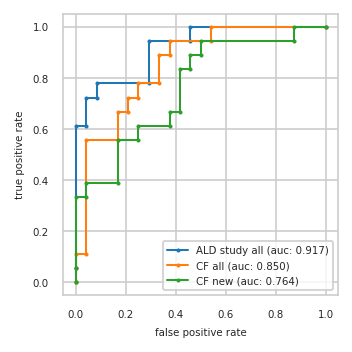

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.611  0.000 0.111  0.000 0.333
3          0.042 0.611  0.042 0.111  0.042 0.333
4          0.042 0.722  0.042 0.556  0.042 0.389
5          0.083 0.722  0.167 0.556  0.167 0.389
6          0.083 0.778  0.167 0.667  0.167 0.556
7          0.292 0.778  0.208 0.667  0.250 0.556
8          0.292 0.944  0.208 0.722  0.250 0.611
9          0.458 0.944  0.250 0.722  0.375 0.611
10         0.458 1.000  0.250 0.778  0.375 0.667
11         1.000 1.000  0.333 0.778  0.417 0.667
12           NaN   NaN  0.333 0.889  0.417 0.833
13           NaN   NaN  0.375 0.889  0.458 0.833
14           NaN   NaN  0.375 0.944  0.458 0.889
15           NaN   NaN  0.542 0.944  0.500 0.889
16           NaN   NaN  0.542 1.000  0.500 0.944
17           NaN   NaN  1.000 1.000  0.875 0.944
18           NaN   NaN    NaN   NaN  0.875 1.000
19           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,F5H265,Q13641,P36269;P36269-2;P36269-3
2,P01258;P01258-2;P06881,Q01995,J3KSJ8;Q9UD71;Q9UD71-2
3,P61981,Q0P6D2,P51688
4,P14174,Q14894,Q96GD0
5,P04075,Q9Y2T3;Q9Y2T3-3,A0A075B7B8
6,P00338;P00338-3,P25189;P25189-2,P31321
7,C9JF17;P05090,P63104,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,Q9Y2T3;Q9Y2T3-3,P04075,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


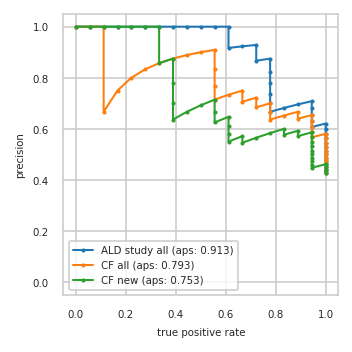

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.567 0.944     0.567 0.944
13         0.621 1.000     0.586 0.944     0.586 0.944
14         0.607 0.944     0.607 0.944     0.571 0.889
15         0.630 0.944     0.630 0.944     0.593 0.889
16         0.654 0.944     0.654 0.944     0.577 0.833
17         0.680 0.944     0.640 0.889     0.600 0.833
18         0.708 0.944     0.667 0.889     0.583 0.778
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.667 0.778     0.667 0.778     0.571 0.667
22         0.700 0.778     0.700 0.778     0.550 0.611
23         0.737 0.778     0.684 0.722     0.579 0.611
24         0.778 0.778     0.722 0.722     0.611 0.611
25         0.824 0.778     0.706 0.667     0.647 0.611
26         0.875 0.778     0.750 0.667     0.625 0.556
27         0.867 0.722     0.733 0.611     0.667 0.556
28         0.929 0.722     0.714 0.556     0.714 0.556
29         0.923 0.667     0.769 0.556     0.692 0.500
30         0.917 0.611     0.833 0.556     0.667 0.444
31         1.000 0.611     0.909 0.556     0.636 0.389
32         1.000 0.556     0.900 0.500     0.700 0.389
33         1.000 0.500     0.889 0.444     0.778 0.389
34         1.000 0.444     0.875 0.389     0.875 0.389
35         1.000 0.389     0.857 0.333     0.857 0.333
36         1.000 0.333     0.833 0.278     1.000 0.333
37         1.000 0.278     0.800 0.222     1.000 0.278
38         1.000 0.222     0.750 0.167     1.000 0.222
39         1.000 0.167     0.667 0.111     1.000 0.167
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


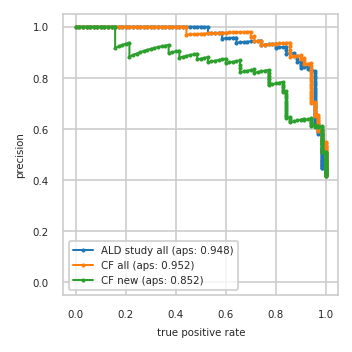

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


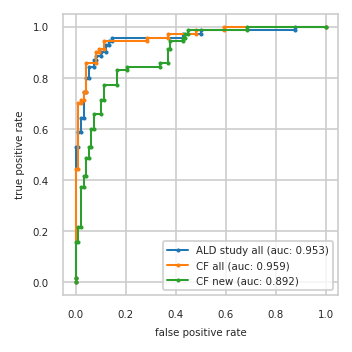

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}